In [1]:
!pip install category_encoders
from category_encoders import JamesSteinEncoder
from functools import reduce
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
from itertools import chain
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00


In [2]:
path = kagglehub.dataset_download("asaniczka/tmdb-movies-dataset-2023-930k-movies")
movies = pd.read_csv(path + "/TMDB_movie_dataset_v11.csv")

100%|██████████| 209M/209M [00:03<00:00, 55.8MB/s]

Extracting files...


Number of rows: 1175455
Number of rows with revenue below 0: 1
Number of rows with revenue equals to 0: 1154153
Number of rows with revenue greater 200000000: 989
<class 'pandas.core.frame.DataFrame'>
Index: 20312 entries, 7 to 1175417
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    20312 non-null  Int64  
 1   title                 20312 non-null  string 
 2   vote_average          20312 non-null  Float64
 3   vote_count            20312 non-null  Int64  
 4   status                20312 non-null  string 
 5   release_date          18177 non-null  string 
 6   revenue               20312 non-null  Int64  
 7   runtime               20312 non-null  Int64  
 8   adult                 20312 non-null  boolean
 9   backdrop_path         15270 non-null  string 
 10  budget                20312 non-null  Int64  
 11  homepage              5623 non-null   string 
 12  imdb_id     

,Percentage of Nulls
id,0.0%
title,0.0%
vote_average,0.0%
vote_count,0.0%
status,0.0%
release_date,10.51%
revenue,0.0%
runtime,0.0%
adult,0.0%
backdrop_path,24.82%


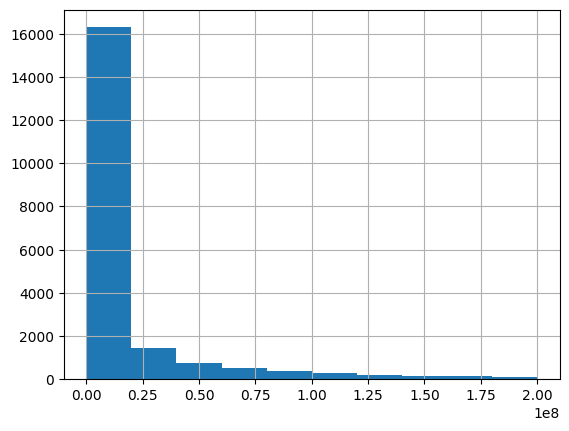

In [11]:
clean_movies = movies.convert_dtypes()
print('Number of rows: ' + str(len(clean_movies)))
print('Number of rows with revenue below 0: ' + str(len(clean_movies[clean_movies['revenue'].lt(0)])))
print('Number of rows with revenue equals to 0: ' + str(len(clean_movies[clean_movies['revenue'].eq(0)])))
print('Number of rows with revenue greater 200000000: ' + str(len(clean_movies[clean_movies['revenue'].gt(200000000)])))
clean_movies.drop(clean_movies[clean_movies['revenue'].le(0) | clean_movies['revenue'].gt(200000000)].index, inplace=True)
clean_movies.info()
print('Number of rows: ' + str(len(clean_movies)))
clean_movies['revenue'].hist()
clean_movies.head()
(clean_movies.isnull().sum() / len(clean_movies)).mul(100).round(2).astype(str).add('%').rename('Percentage of Nulls')

In [12]:
def create_frequency_dict(series):
  word_frequency = {}
  for list in series:
    if pd.isnull(list):
      break

    words = list.split(', ')
    for w in words:
      if w in word_frequency.keys():
        frequency = word_frequency[w] + 1
      else:
        frequency = 1
      word_frequency[w] = frequency

  return {k: v for k, v in sorted(word_frequency.items(), key=lambda item: item[1], reverse=True)}

clean_movies['release_year'] = clean_movies.release_date.str.split('-').str[0]
clean_movies['release_month'] = clean_movies.release_date.str.split('-').str[1]
clean_movies['release_year'].fillna('2017', inplace=True)
clean_movies['release_month'].fillna('09', inplace=True)
genres_frequency_dict = create_frequency_dict(clean_movies['genres'])
production_countries_frequency_dict = create_frequency_dict(clean_movies['production_countries'])
production_companies_frequency_dict = create_frequency_dict(clean_movies['production_companies'])
spoken_languages_frequency_dict = create_frequency_dict(clean_movies['spoken_languages'])
original_language_frequency_dict = create_frequency_dict(clean_movies['original_language'])
keywords_frequency_dict = create_frequency_dict(clean_movies['keywords'])
release_month_frequency_dict = create_frequency_dict(clean_movies['release_month'])

print(genres_frequency_dict)
print(production_countries_frequency_dict)
print(production_companies_frequency_dict)
print(spoken_languages_frequency_dict)
print(original_language_frequency_dict)
print(keywords_frequency_dict)
print(release_month_frequency_dict)

{'Drama': 4961, 'Comedy': 3600, 'Thriller': 2496, 'Action': 2154, 'Romance': 1905, 'Crime': 1531, 'Adventure': 1328, 'Horror': 1296, 'Science Fiction': 917, 'Mystery': 867, 'Fantasy': 847, 'Family': 847, 'Animation': 557, 'History': 539, 'War': 368, 'Music': 342, 'Documentary': 213, 'Western': 162, 'TV Movie': 14}
{'United States of America': 5105, 'United Kingdom': 1053, 'France': 808, 'Germany': 446, 'Canada': 404, 'Japan': 277, 'Italy': 232, 'Spain': 181, 'Belgium': 152, 'Australia': 146, 'China': 116, 'Hong Kong': 108, 'Ireland': 83, 'South Korea': 77, 'India': 76, 'Sweden': 73, 'Denmark': 67, 'Mexico': 50, 'Netherlands': 46, 'Russia': 43, 'Switzerland': 40, 'Czech Republic': 38, 'Norway': 32, 'New Zealand': 31, 'Brazil': 30, 'South Africa': 30, 'Hungary': 27, 'Luxembourg': 25, 'Argentina': 23, 'Finland': 21, 'Poland': 20, 'Romania': 20, 'United Arab Emirates': 19, 'Bulgaria': 17, 'Turkey': 16, 'Morocco': 16, 'Austria': 15, 'Greece': 12, 'Thailand': 12, 'Chile': 12, 'Colombia': 10,

In [13]:
def fill_column(value):
  def f(text):
    if pd.isnull(text):
      return 0
    values = text.split(', ')
    if value in values:
      return 1
    return 0

  return f

def fill_columns(column_name, values):
  for v in values:
    clean_movies[f"{column_name}_{v.strip().lower().replace(' ', '_')}"] = clean_movies[column_name].apply(fill_column(v))
#  clean_movies.drop(columns=[column_name], inplace=True)

fill_columns('genres', genres_frequency_dict.keys())
fill_columns('production_countries', list(production_countries_frequency_dict.keys())[1:20])
fill_columns('production_companies', list(production_companies_frequency_dict.keys())[1:20])
fill_columns('spoken_languages', list(spoken_languages_frequency_dict.keys()))
fill_columns('original_language', list(original_language_frequency_dict.keys()))
fill_columns('keywords', list(keywords_frequency_dict.keys())[1:22])
fill_columns('release_month', list(release_month_frequency_dict.keys()))
clean_movies.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,release_month_08,release_month_12,release_month_01,release_month_03,release_month_04,release_month_11,release_month_05,release_month_06,release_month_02,release_month_07
7,550,Fight Club,8.438,27238,Released,1999-10-15,100853753,139,False,/hZkgoQYus5vegHoetLkCJzb17zJ.jpg,...,0,0,0,0,0,0,0,0,0,0
14,278,The Shawshank Redemption,8.702,24649,Released,1994-09-23,28341469,142,False,/kXfqcdQKsToO0OUXHcrrNCHDBzO.jpg,...,0,0,0,0,0,0,0,0,0,0
63,245891,John Wick,7.421,17923,Released,2014-10-22,88761661,101,False,/7dzngS8pLkGJpyeskCFcjPO9qLF.jpg,...,0,0,0,0,0,0,0,0,0,0
86,694,The Shining,8.218,16205,Released,1980-05-23,44781695,144,False,/AdKA2F1SzYPhSZdEbjH1Zh75UVQ.jpg,...,0,0,0,0,0,0,1,0,0,0
87,24,Kill Bill: Vol. 1,7.97,16188,Released,2003-10-10,180906076,111,False,/k9Ps0EsrTnqbQ4oTTWx628BQ2TW.jpg,...,0,0,0,0,0,0,0,0,0,0


In [14]:
categorical_columns = [ 'adult' ]
one_hot_columns = []
for c in clean_movies.columns:
  if c.startswith('genres_') or c.startswith('production_companies_') or c.startswith('production_countries_') or c.startswith('spoken_languages_') or c.startswith('original_language_') or c.startswith('keywords_') or c.startswith('release_month_'):
    one_hot_columns.append(c)
numerical_columns = ['budget', 'popularity', 'release_year', 'runtime', 'vote_average', 'vote_count']

In [15]:
#for column in categorical_columns:
#  plt.figure(figsize=(15,4))
#  mean_price = clean_movies.groupby(column)['revenue'].mean()
#  bar_plot = sns.barplot(mean_price)
#  bar_plot.set(xlabel='Counts', ylabel='Categories', title='Column {0} Mean Price'.format(column.capitalize()))
#  bar_plot.bar_label(bar_plot.containers[0])

In [16]:
results = []

def run_model(name, pipe, transformer, X_train, X_test, y_train, y_test):
  pipe.fit(X_train, y_train)
  pred_train = pipe.predict(X_train)
  pred_test = pipe.predict(X_test)
  train_mse = mean_squared_error(y_train, pred_train)
  train_mae = mean_absolute_error(y_train, pred_train)
  test_mse = mean_squared_error(y_test, pred_test)
  test_mae = mean_absolute_error(y_test, pred_test)
  r2 = r2_score(y_test, pred_test)
  plt.scatter(X_test.index, y_test)
  plt.plot(X_test.index, pred_test, color='red')
  plt.xlabel("Independent Variable")
  plt.ylabel("Dependent Variable")
  plt.show()
  coefs = []
  try:
    feature_names = transformer.get_feature_names_out()
    if hasattr(pipe['linreg'], 'coef_'):
      for index in range(0, len(pipe['linreg'].coef_)):
        coef = pipe['linreg'].coef_[index]
        try:
          numerical_column_index = numerical_columns.index(feature_names[index])
          coef = coef / transformer['standardscaler'].scale_[numerical_column_index] / clean_movies[feature_names[index]].std()
        except ValueError:
          pass
        coefs.append({ 'Feature Name': feature_names[index], 'Coefficient': coef })
  except:
    pass
  result = { 'Model': name, 'Train MSE': train_mse, 'Test MSE': test_mse, 'Train MAE': train_mae, 'Test MAE': test_mae, 'R2 Score': r2, 'Coefficients': coefs }
  results.append(results)
  return result

In [17]:
X = clean_movies[categorical_columns + one_hot_columns + numerical_columns]
y = clean_movies['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

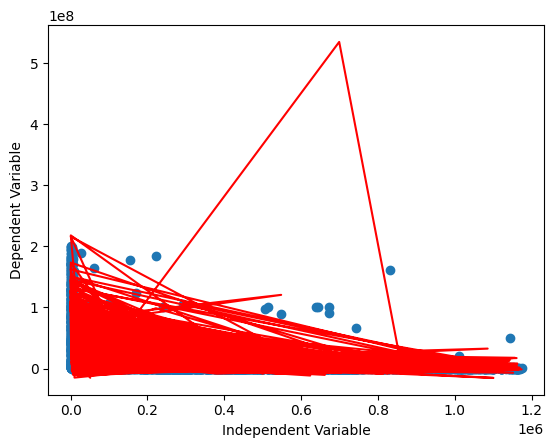

,Feature Name,Coefficient
92,remainder__spoken_languages_esperanto,-2.808857e+07
201,remainder__original_language_my,-2.051108e+07
216,remainder__keywords_dystopia,-1.543111e+07
180,remainder__original_language_sq,-1.467508e+07
188,remainder__original_language_af,-1.317349e+07
112,remainder__spoken_languages_yiddish,-1.199018e+07
166,remainder__original_language_sk,-1.162643e+07
206,remainder__original_language_sa,-1.057172e+07
183,remainder__original_language_mk,-1.051050e+07
165,remainder__original_language_ka,-9.450162e+06


In [18]:
transformer = make_column_transformer((OneHotEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns),
                                      remainder='passthrough')
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
result = run_model('Model', pipe, transformer, X_train, X_test, y_train, y_test)
pd.DataFrame(result)
pd.set_option('display.max_rows', None)
coef_df = pd.DataFrame(result['Coefficients']).sort_values('Coefficient')
coef_df

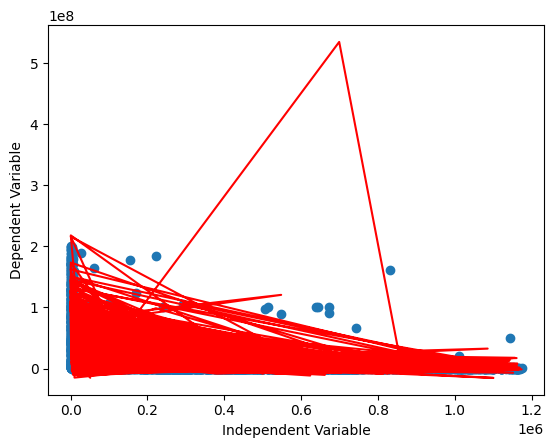

,Feature Name,Coefficient
86,jamessteinencoder__spoken_languages_esperanto,-2.808857e+07
195,jamessteinencoder__original_language_my,-2.051108e+07
210,jamessteinencoder__keywords_dystopia,-1.543111e+07
174,jamessteinencoder__original_language_sq,-1.467508e+07
182,jamessteinencoder__original_language_af,-1.317349e+07
106,jamessteinencoder__spoken_languages_yiddish,-1.199018e+07
160,jamessteinencoder__original_language_sk,-1.162643e+07
200,jamessteinencoder__original_language_sa,-1.057172e+07
177,jamessteinencoder__original_language_mk,-1.051050e+07
159,jamessteinencoder__original_language_ka,-9.450162e+06


In [19]:
transformer = make_column_transformer((OneHotEncoder(),
                                      categorical_columns),
                                      (JamesSteinEncoder(),
                                      one_hot_columns),
                                      (StandardScaler(),
                                      numerical_columns),
                                      remainder='passthrough')
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
result = run_model('Model', pipe, transformer, X_train, X_test, y_train, y_test)
pd.DataFrame(result)
pd.set_option('display.max_rows', None)
coef_df = pd.DataFrame(result['Coefficients']).sort_values('Coefficient')
coef_df

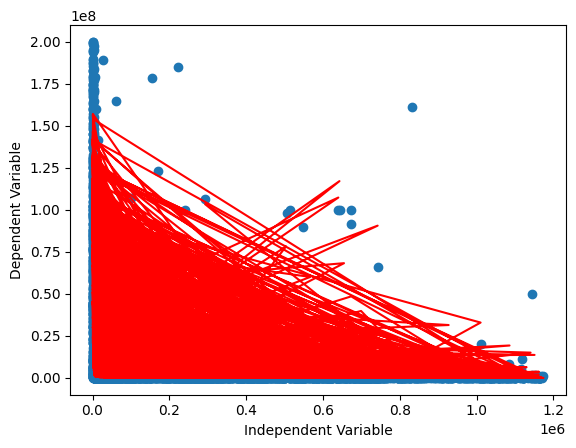

,Model,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score,Coefficients


In [20]:
transformer = make_column_transformer((OneHotEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns),
                                      remainder='passthrough')
pipe = Pipeline([('transformer', transformer), ('linreg', RandomForestRegressor())])
result = run_model('Model', pipe, transformer, X_train, X_test, y_train, y_test)
pd.DataFrame(result)


In [ ]:
transformer = make_column_transformer((OneHotEncoder(),
                                      [ 'adult' ]),
                                      (StandardScaler(),
                                      numerical_columns),
                                      (PolynomialFeatures(include_bias = False),
                                      numerical_columns),
                                      remainder='passthrough')
pipe = Pipeline([('transformer', transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
result = run_model('Model', grid, transformer, X_train, X_test, y_train, y_test)
pd.DataFrame(result)
pd.DataFrame(grid.best_params_)
pd.set_option('display.max_rows', None)


{'Model': 'Model', 'Train MSE': 512560731022030.0, 'Test MSE': 607246263240511.0, 'Train MAE': 11286307.597646574, 'Test MAE': 11337297.573163582, 'R2 Score': 0.4522079797955556, 'Coefficients': []}
{'transformer__polynomialfeatures__degree': 2}


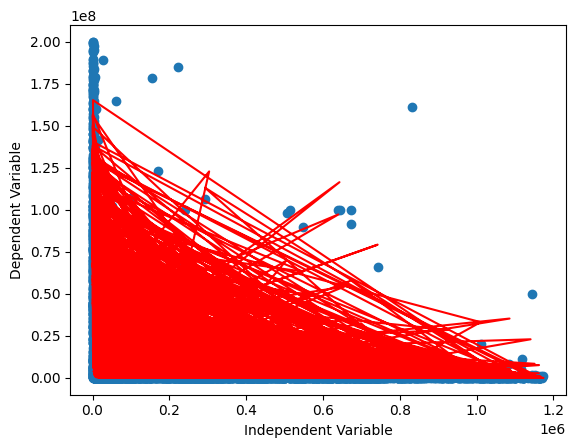

{'Model': 'Model', 'Train MSE': 59230975320822.12, 'Test MSE': 417054961284360.1, 'Train MAE': 3606357.3807809763, 'Test MAE': 9862181.527436288, 'R2 Score': 0.6237780393096293, 'Coefficients': []}


In [ ]:
transformer = make_column_transformer((OneHotEncoder(),
                                      categorical_columns),
                                      (StandardScaler(),
                                      numerical_columns),
                                      (PolynomialFeatures(include_bias = False, degree=2),
                                      numerical_columns),
                                      remainder='passthrough')
pipe = Pipeline([('transformer', transformer), ('linreg', RandomForestRegressor())])
result = run_model('Model', pipe, transformer, X_train, X_test, y_train, y_test)
pd.DataFrame(result)